In [2]:
import torch
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset=Planetoid(root="data/Planetoid",name="PubMed",transform=NormalizeFeatures())

print(f"dataset{dataset}")
print("x"*50)
print(f"number of graphs: {len(dataset)}")
print(f"number of features: {dataset.num_features}")
print(f"number of classes:{dataset.num_classes}")

data=dataset[0]

print("*"*30)
print(data)
print("="*50)

print(f'Number of nodes:{data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree:{data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes:{data.train_mask.sum()}')
print(f'Training node label rate:{int(data.train_mask.sum()) / data.num_nodes:.3f}')
print(f'Has isolated nodes:{data.has_isolated_nodes()}')
print(f'Has self-loops:{data.has_self_loops()}')
print(f'Is undirected:{data.is_undirected()}')


datasetPubMed()
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
number of graphs: 1
number of features: 500
number of classes:3
******************************
Data(x=[19717, 500], edge_index=[2, 88648], y=[19717], train_mask=[19717], val_mask=[19717], test_mask=[19717])
Number of nodes:19717
Number of edges: 88648
Average node degree:4.50
Number of training nodes:60
Training node label rate:0.003
Has isolated nodes:False
Has self-loops:False
Is undirected:True


In [3]:
print(int(data.train_mask.sum()))
print(int(data.val_mask.sum()))
print(int(data.test_mask.sum()))

60
500
1000


类别0:4103个样本
类别1:7739个样本
类别2:7875个样本


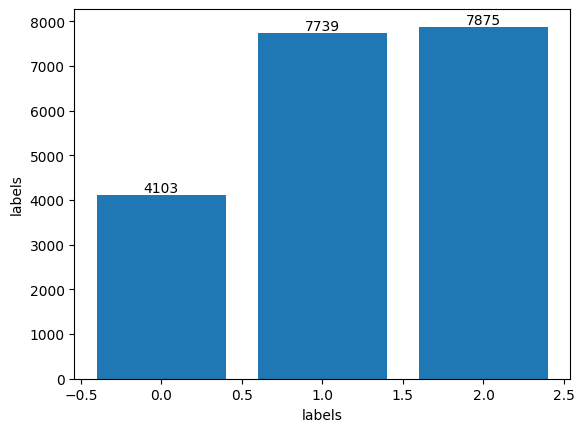

In [4]:
import matplotlib.pyplot as plt

unique_labels,counts=torch.unique(data.y,return_counts=True)

for label,count in zip(unique_labels,counts):
    print(f"类别{label.item()}:{count.item()}个样本")

plt.bar(unique_labels.numpy(),counts.numpy())
plt.xlabel("labels")
plt.ylabel("labels")

for label,count in zip(unique_labels,counts):
    plt.text(label.item(),count.item(),str(count.item()),ha="center",va="bottom")

plt.show()



In [5]:
import torch.nn as nn
from torch_geometric.nn import ClusterGCNConv
import torch.nn.functional as F

class ClusterGCN(nn.Module):
    def __init__(self,output_channels=3):
        super(ClusterGCN, self).__init__()

        self.conv1=ClusterGCNConv(500,32,diag_lambda=1)
        self.conv2=ClusterGCNConv(32,output_channels,diag_lambda=1)

        self.dp=nn.Dropout(p=0.5)

    def forward(self,x,edge_index):
        x=F.relu(self.conv1(x,edge_index))
        x=self.conv2(x,edge_index)

        return x
    
model=ClusterGCN()
print(model)

total_params=sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"total:{total_params}")

ClusterGCN(
  (conv1): ClusterGCNConv(500, 32, diag_lambda=1)
  (conv2): ClusterGCNConv(32, 3, diag_lambda=1)
  (dp): Dropout(p=0.5, inplace=False)
)
total:32227


In [8]:
for layer in model.children():
    if hasattr(layer,"reset_parameters"):
        layer.reset_parameters()

In [11]:
import time 
from numpy import arange
import torch.optim as optim
import torch.nn.functional as F

device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model=model.to(device)

optimizer=optim.Adam(model.parameters(),lr=0.01,weight_decay=1e-4)
criterion=nn.CrossEntropyLoss(reduction="mean")

data=data.to(device)

def train():
    model.train()
    optimizer.zero_grad()
    train_outputs=model(data.x,data.edge_index)
    loss=criterion(train_outputs[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    
    return loss

def test():
    model.eval()
    outputs=model(data.x,data.edge_index)
    preds=outputs.argmax(dim=1)

    accs=[]
    for mask in [data.train_mask,data.val_mask,data.test_mask]:
        correct=preds[mask]==data.y[mask]
        accs.append(int(correct.sum())/int(mask.sum()))
    return accs

start=time.time()

for epoch in arange(100):
    loss=train()

    train_acc,val_acc,test_acc=test()

    if epoch%10==0:
        print(f"epoch is {epoch},loss is {loss},train_acc is {train_acc},val_acc is {val_acc},test_acc{test_acc}")

end=time.time()
time_total=end-start
print(f"time is {time_total}")



epoch is 0,loss is 0.4650663137435913,train_acc is 0.9833333333333333,val_acc is 0.744,test_acc0.743
epoch is 10,loss is 0.07603111863136292,train_acc is 1.0,val_acc is 0.754,test_acc0.755
epoch is 20,loss is 0.013447721488773823,train_acc is 1.0,val_acc is 0.744,test_acc0.75
epoch is 30,loss is 0.005504921078681946,train_acc is 1.0,val_acc is 0.75,test_acc0.751
epoch is 40,loss is 0.004957630764693022,train_acc is 1.0,val_acc is 0.758,test_acc0.751
epoch is 50,loss is 0.0060208505019545555,train_acc is 1.0,val_acc is 0.76,test_acc0.758
epoch is 60,loss is 0.007003015838563442,train_acc is 1.0,val_acc is 0.766,test_acc0.768
epoch is 70,loss is 0.006992482580244541,train_acc is 1.0,val_acc is 0.772,test_acc0.773
epoch is 80,loss is 0.006364787928760052,train_acc is 1.0,val_acc is 0.768,test_acc0.773
epoch is 90,loss is 0.005717886611819267,train_acc is 1.0,val_acc is 0.768,test_acc0.776
time is 2.6400535106658936
